In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error # 0.3 error
import statsmodels.formula.api as smf
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [3]:
df = pd.read_csv('googleplaystore.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


In [5]:
df['totalwords'] = df['App'].str.split().str.len()

In [6]:
#clean size column
df['Size'] = df['Size'].map(lambda x: x.rstrip('M'))
#divide by 1024 to convert K values to MB
df['Size'] = df['Size'].map(lambda x: str(round((float(x.rstrip('k'))/1024), 1)) if x[-1]=='k' else x)
df['Size'] = df['Size'].apply(lambda x: 0 if x.startswith('Varies') else x)
# df['col'] = df['col'].apply(lambda x: f"str{x}")
# df['Size'] = df['Size'].apply(lambda x: f"{x}MB")


In [7]:
# Data cleaning for "Installs" column
df['Installs'] = df['Installs'].map(lambda x: x.rstrip('+'))
df['Installs'] = df['Installs'].map(lambda x: ''.join(x.split(',')))

In [8]:
# Data cleaning for "Price" column
df['Price'] = df['Price'].map(lambda x: x.lstrip('$').rstrip())

In [9]:
# splitting Genres into one simple category
df['Genres'] = df['Genres'].apply(lambda x : x.split(";")[0])

In [10]:
# Remove Row 10472 missing value of Category
df.drop(df.index[10472], inplace=True)
# Row [7312,8266] removed due to "Unrated" value in Content Rating
df.drop(df.index[[7312,8266]], inplace=True)

In [11]:
df['Reviews'] = df['Reviews'].astype(int)
# df['Size'] = df['Size'].astype(float)
df['Installs'] = df['Installs'].astype(int)
df['Price'] = df['Price'].astype(float)
df['Last Updated'] = pd.to_datetime(df['Last Updated'])

In [12]:
df = df.rename(columns={'Size': 'Size_MB'})

In [13]:
# df = df.rename(columns={'Size': 'Size_MB'}
df = df.rename(columns = {'Content Rating': 'Content_Rating','Last Updated': 'Last_Updated'})

In [14]:
#Rating column fill with median
df['Rating'].fillna((df['Rating'].median()), inplace = True)

In [15]:
#drop Android version column
df = df.drop(['Android Ver'], axis=1)

In [16]:
df.Type.fillna('Free', inplace=True)

In [17]:
df = df.dropna()

In [18]:
# Sort by "Category"
df.sort_values("Category", inplace = True)

#### Need to change data from categorical to numeric types so we can conduct a regression
#### categories to change are Category and Content Rating

In [19]:
# df['shift'] = df['pickup_hour'].apply(lambda x: 'AM' if x in range(5,16) else 'PM')
df['above_4'] = df['Rating'].apply(lambda x: 1 if x >= 4 else 0)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder().fit_transform(df['above_4'])
df.loc[:,'above4'] = le

#ratings above 4
# df['above4'] = df['above_4'].astype('category').cat.codes

In [20]:
df['above3'] = df['Rating'].apply(lambda x: 1 if x >= 3 else 0)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder().fit_transform(df['above3'])
df.loc[:,'above3'] = le

In [21]:
le = LabelEncoder().fit_transform(df['Content_Rating'])
df.loc[:,'Content_Rating_Num'] = le
# df.head()
# df['Content_Rating_Num'] = df['Content Rating'].astype('category').cat.codes

In [22]:
le = LabelEncoder().fit_transform(df['Genres'])
df.loc[:,'Genres_Num'] = le

In [23]:
le = LabelEncoder().fit_transform(df['Category'])
df.loc[:,'Category_Num'] = le
# df['Category_Num'] = df['Category'].astype('category').cat.codes

In [24]:
df = df.drop(['above_4'], axis=1)

In [25]:
# Change datatype
df['Reviews'] = pd.to_numeric(df['Reviews'])
df['Installs'] = pd.to_numeric(df['Installs'])
df['Price'] = df['Price'].astype(float)
df['Size_MB'] = df['Size_MB'].astype(float)

In [26]:
# df = df.drop(df[df.Size_MB == 0].index)
# df = df.drop(['installs_price'],axis=1)

In [27]:
import datetime
# df['day'] = df['datetime_utc'].dt.day
df['year'] = df['Last_Updated'].dt.year

In [28]:
df['justdate'] = df['Last_Updated'].dt.date

In [29]:
df['month'] = df['Last_Updated'].dt.month

In [30]:
import datetime as dt
df['date'] = pd.to_datetime(df['Last_Updated'])
df['date']=df['date'].map(dt.datetime.toordinal)

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10830 entries, 0 to 3647
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   App                 10830 non-null  object        
 1   Category            10830 non-null  object        
 2   Rating              10830 non-null  float64       
 3   Reviews             10830 non-null  int64         
 4   Size_MB             10830 non-null  float64       
 5   Installs            10830 non-null  int64         
 6   Type                10830 non-null  object        
 7   Price               10830 non-null  float64       
 8   Content_Rating      10830 non-null  object        
 9   Genres              10830 non-null  object        
 10  Last_Updated        10830 non-null  datetime64[ns]
 11  Current Ver         10830 non-null  object        
 12  totalwords          10830 non-null  int64         
 13  above4              10830 non-null  int64      

# EXPLORING

In [32]:
df['Size_MB'].value_counts().sort_values(ascending=True)

90.0        6
86.0        8
89.0        9
84.0        9
65.0       10
79.0       11
81.0       11
80.0       13
87.0       13
75.0       13
77.0       13
71.0       14
88.0       14
64.0       15
73.0       15
83.0       15
92.0       15
9.3        15
9.6        15
1.0        16
100.0      16
98.0       16
93.0       16
66.0       16
94.0       17
85.0       17
95.0       18
68.0       18
72.0       19
74.0       20
97.0       20
82.0       21
91.0       22
0.7        22
69.0       23
8.0        23
78.0       23
9.4        24
0.6        24
9.7        24
8.6        25
6.7        25
7.1        26
0.8        26
58.0       26
96.0       26
7.7        26
61.0       26
70.0       27
76.0       27
8.8        27
9.0        27
8.1        27
9.5        28
7.4        28
8.9        28
7.5        28
9.9        28
0.5        28
6.8        28
6.4        28
8.2        28
0.4        29
7.2        29
9.1        29
7.6        29
7.8        29
54.0       29
9.8        30
6.2        30
55.0       30
8.4   

In [33]:
#rating by category
cat_rating = df.groupby('Category')['Rating'].mean().sort_values(ascending=False) 
len(cat_rating)

33

In [34]:
#rating in GAME - genres
genre_rating = df.groupby('Category')
genre_rating = genre_rating.get_group('GAME')
genre_rating = genre_rating.groupby('Genres').mean()
genre_rating['Rating'].sort_values(ascending=False)

Genres
Sports          4.535714
Puzzle          4.526190
Casual          4.444898
Word            4.406897
Role Playing    4.400000
Strategy        4.395833
Simulation      4.392308
Arcade          4.304091
Board           4.293182
Casino          4.287179
Action          4.286413
Music           4.218182
Adventure       4.203750
Racing          4.179592
Trivia          4.107895
Card            4.100000
Name: Rating, dtype: float64

In [35]:
#INSTALLS in GAME - genres
genre_rating = df.groupby('Category')
genre_rating = genre_rating.get_group('GAME')
genre_rating = genre_rating.groupby('Genres').sum()
genre_rating['Installs'].sort_values(ascending=False)

Genres
Arcade          10727129155
Action           9367039190
Casual           7119000000
Racing           2000247320
Puzzle           1189200000
Strategy         1157300000
Sports           1116000000
Adventure         906695320
Music             320120500
Word              269172550
Simulation        211200000
Board             167127210
Card              162826100
Casino            130260700
Trivia            128606370
Role Playing      114100000
Name: Installs, dtype: int64

In [36]:
genre_rating = df.groupby('Category')
genre_rating = genre_rating.get_group('FAMILY')
genre_rating = genre_rating.groupby('Genres').sum()
genre_rating['Installs'].sort_values(ascending=False)

Genres
Casual                     3346313740
Entertainment              2571444184
Strategy                    819487605
Puzzle                      791236811
Simulation                  680108320
Education                   482530608
Adventure                   426250000
Educational                 408300966
Role Playing                320440770
Racing                      213260000
Arcade                       66210001
Action                       63020500
Video Players & Editors      20000000
Board                        13887200
Card                         11100000
Sports                       10700000
Music                        10101000
Art & Design                  1600000
Health & Fitness              1100000
Communication                  500000
Music & Audio                  500000
Lifestyle                      100000
Books & Reference               11100
Trivia                            100
Name: Installs, dtype: int64

In [37]:
#REVIEWS in GAME - genres
genre_rating = df.groupby('Category')
genre_rating = genre_rating.get_group('GAME')
genre_rating = genre_rating.groupby('Genres').sum()
genre_rating['Reviews'].sort_values(ascending=False)

Genres
Action          351089374
Arcade          336990433
Casual          318723943
Strategy        230117074
Sports          122047448
Racing           89096887
Adventure        51975021
Puzzle           34754422
Simulation        9194201
Trivia            7175955
Card              6852815
Word              6828543
Music             5689921
Role Playing      5448694
Casino            5103971
Board             4333647
Name: Reviews, dtype: int64

In [38]:
year_rating = df.groupby('year')['Rating'].mean()
year_rating

year
2010    4.200000
2011    3.966667
2012    3.876000
2013    4.106422
2014    4.061722
2015    4.102838
2016    4.090399
2017    4.135139
2018    4.251055
Name: Rating, dtype: float64

In [39]:
cat_installs = df.groupby('Category')['Installs'].sum().sort_values(ascending=False) 
cat_installs

Category
GAME                   35086024415
COMMUNICATION          32647276251
PRODUCTIVITY           14176091369
SOCIAL                 14069867902
TOOLS                  11452221905
FAMILY                 10258202905
PHOTOGRAPHY            10088247655
NEWS_AND_MAGAZINES      7496317760
TRAVEL_AND_LOCAL        6868887146
VIDEO_PLAYERS           6222002720
SHOPPING                3247848785
ENTERTAINMENT           2869160000
PERSONALIZATION         2325494782
BOOKS_AND_REFERENCE     1921468576
SPORTS                  1751174498
HEALTH_AND_FITNESS      1583072512
BUSINESS                1001914865
FINANCE                  876648734
EDUCATION                871452000
MAPS_AND_NAVIGATION      724281890
LIFESTYLE                537643539
WEATHER                  426100520
FOOD_AND_DRINK           273898751
DATING                   264310807
HOUSE_AND_HOME           168712461
ART_AND_DESIGN           124333100
LIBRARIES_AND_DEMO        61995910
COMICS                    56086150
MEDICAL    

In [40]:
#create total apps in category add that into model 
cat_total = df.groupby('Category')['App'].count()
cat_total

Category
ART_AND_DESIGN           64
AUTO_AND_VEHICLES        85
BEAUTY                   53
BOOKS_AND_REFERENCE     230
BUSINESS                460
COMICS                   60
COMMUNICATION           387
DATING                  234
EDUCATION               156
ENTERTAINMENT           149
EVENTS                   64
FAMILY                 1968
FINANCE                 366
FOOD_AND_DRINK          127
GAME                   1144
HEALTH_AND_FITNESS      341
HOUSE_AND_HOME           88
LIBRARIES_AND_DEMO       84
LIFESTYLE               382
MAPS_AND_NAVIGATION     137
MEDICAL                 463
NEWS_AND_MAGAZINES      283
PARENTING                60
PERSONALIZATION         392
PHOTOGRAPHY             335
PRODUCTIVITY            424
SHOPPING                260
SOCIAL                  295
SPORTS                  384
TOOLS                   840
TRAVEL_AND_LOCAL        258
VIDEO_PLAYERS           175
WEATHER                  82
Name: App, dtype: int64

In [41]:
#avg rating per cat
cat_rating = df.groupby('Category')['Rating'].mean()
cat_rating

Category
ART_AND_DESIGN         4.373437
AUTO_AND_VEHICLES      4.205882
BEAUTY                 4.283019
BOOKS_AND_REFERENCE    4.335652
BUSINESS               4.182391
COMICS                 4.160000
COMMUNICATION          4.180103
DATING                 4.025641
EDUCATION              4.388462
ENTERTAINMENT          4.126174
EVENTS                 4.395313
FAMILY                 4.204522
FINANCE                4.151639
FOOD_AND_DRINK         4.185827
GAME                   4.286888
HEALTH_AND_FITNESS     4.280059
HOUSE_AND_HOME         4.211364
LIBRARIES_AND_DEMO     4.208333
LIFESTYLE              4.131414
MAPS_AND_NAVIGATION    4.075182
MEDICAL                4.216199
NEWS_AND_MAGAZINES     4.161837
PARENTING              4.300000
PERSONALIZATION        4.328827
PHOTOGRAPHY            4.197910
PRODUCTIVITY           4.226651
SHOPPING               4.263077
SOCIAL                 4.261017
SPORTS                 4.236458
TOOLS                  4.079643
TRAVEL_AND_LOCAL       4.132946

In [42]:
#avg installs per cat
cat_installs = df.groupby('Category')['Installs'].mean()
cat_installs

Category
ART_AND_DESIGN         1.942705e+06
AUTO_AND_VEHICLES      6.250613e+05
BEAUTY                 5.131519e+05
BOOKS_AND_REFERENCE    8.354211e+06
BUSINESS               2.178076e+06
COMICS                 9.347692e+05
COMMUNICATION          8.435989e+07
DATING                 1.129533e+06
EDUCATION              5.586231e+06
ENTERTAINMENT          1.925611e+07
EVENTS                 2.495806e+05
FAMILY                 5.212501e+06
FINANCE                2.395215e+06
FOOD_AND_DRINK         2.156683e+06
GAME                   3.066960e+07
HEALTH_AND_FITNESS     4.642441e+06
HOUSE_AND_HOME         1.917187e+06
LIBRARIES_AND_DEMO     7.380465e+05
LIFESTYLE              1.407444e+06
MAPS_AND_NAVIGATION    5.286729e+06
MEDICAL                1.150269e+05
NEWS_AND_MAGAZINES     2.648876e+07
PARENTING              5.253518e+05
PERSONALIZATION        5.932385e+06
PHOTOGRAPHY            3.011417e+07
PRODUCTIVITY           3.343418e+07
SHOPPING               1.249173e+07
SOCIAL             

In [43]:
df.head()

,App,Category,Rating,Reviews,Size_MB,Installs,Type,Price,Content_Rating,Genres,Last_Updated,Current Ver,totalwords,above4,above3,Content_Rating_Num,Genres_Num,Category_Num,year,justdate,month,date
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19.0,10000,Free,0.0,Everyone,Art & Design,2018-01-07,1.0.0,9,1,1,1,3,0,2018,2018-01-07,1,736701
35,How to draw Ladybug and Cat Noir,ART_AND_DESIGN,3.8,564,9.2,100000,Free,0.0,Everyone,Art & Design,2018-07-11,2.1,7,0,1,1,3,0,2018,2018-07-11,7,736886
36,UNICORN - Color By Number & Pixel Art Coloring,ART_AND_DESIGN,4.7,8145,24.0,500000,Free,0.0,Everyone,Art & Design,2018-08-02,1.0.9,9,1,1,1,3,0,2018,2018-08-02,8,736908
37,Floor Plan Creator,ART_AND_DESIGN,4.1,36639,0.0,5000000,Free,0.0,Everyone,Art & Design,2018-07-14,Varies with device,3,1,1,1,3,0,2018,2018-07-14,7,736889
38,PIP Camera - PIP Collage Maker,ART_AND_DESIGN,4.7,158,11.0,10000,Free,0.0,Everyone,Art & Design,2017-11-29,1.3,6,1,1,1,3,0,2017,2017-11-29,11,736662


#Regression Models

In [44]:
df.corr()

,Rating,Reviews,Size_MB,Installs,Price,totalwords,above4,above3,Content_Rating_Num,Genres_Num,Category_Num,year,month,date
Rating,1.000000,0.063153,0.037000,0.045473,-0.019333,0.107025,0.765644,0.629385,0.014177,-0.040239,-0.033881,0.124613,0.013314,0.129331
Reviews,0.063153,1.000000,0.065386,0.643113,-0.009675,-0.023920,0.068701,0.024989,0.070096,-0.003800,0.002136,0.075521,0.045877,0.085303
Size_MB,0.037000,0.065386,1.000000,-0.003559,-0.013498,0.019022,0.024829,0.023390,0.135359,-0.113430,-0.126209,0.138839,0.014057,0.144294
Installs,0.045473,0.643113,-0.003559,1.000000,-0.011698,-0.046373,0.060317,0.029835,0.054555,-0.000614,0.022514,0.089347,0.056386,0.100931
Price,-0.019333,-0.009675,-0.013498,-0.011698,1.000000,-0.004211,-0.024343,-0.006406,-0.016191,-0.011400,-0.011965,-0.007992,0.006914,-0.006967
totalwords,0.107025,-0.023920,0.019022,-0.046373,-0.004211,1.000000,0.091306,0.062784,0.068060,-0.005920,-0.029263,0.121543,0.030239,0.129045
above4,0.765644,0.068701,0.024829,0.060317,-0.024343,0.091306,1.000000,0.346996,0.008777,-0.026175,-0.019201,0.120907,0.019156,0.126698
above3,0.629385,0.024989,0.023390,0.029835,-0.006406,0.062784,0.346996,1.000000,0.041387,-0.019305,-0.017237,0.026742,0.008840,0.028918
Content_Rating_Num,0.014177,0.070096,0.135359,0.054555,-0.016191,0.068060,0.008777,0.041387,1.000000,-0.120642,-0.093675,0.055433,0.045855,0.065245
Genres_Num,-0.040239,-0.003800,-0.113430,-0.000614,-0.011400,-0.005920,-0.026175,-0.019305,-0.120642,1.000000,0.803770,0.014958,0.010119,0.016577


In [45]:
#export csv
df.to_csv('googleplay.csv')

# Logistic Model

In [46]:
df['above4'].value_counts(normalize=True)

1    0.815605
0    0.184395
Name: above4, dtype: float64

In [47]:

from sklearn.model_selection import train_test_split
#version 3
def statsmodels_train_test_split(df, stratify=None, **kwargs):

    if stratify is None:
        y, X = df.iloc[:,0], df.drop(columns=df.columns[0])
        X_train, X_test, y_train, y_test = train_test_split(X,y, **kwargs)
    else:
        y, X = stratify, df.drop(columns = stratify.name)
        X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y, **kwargs)
    
    return pd.concat([X_train, y_train], axis=1), pd.concat([X_test, y_test], axis=1)

In [48]:
train, test = statsmodels_train_test_split(df)

In [49]:
df.columns

Index(['App', 'Category', 'Rating', 'Reviews', 'Size_MB', 'Installs', 'Type',
       'Price', 'Content_Rating', 'Genres', 'Last_Updated', 'Current Ver',
       'totalwords', 'above4', 'above3', 'Content_Rating_Num', 'Genres_Num',
       'Category_Num', 'year', 'justdate', 'month', 'date'],
      dtype='object')

In [50]:
formula = 'above4 ~  Reviews + Installs + Size_MB + C(Type)'
# formula = 'above4 ~  Size_MB + C(Category) + C(Content_Rating) + Price + C(Genres)'

In [51]:
fitted_model = smf.logit(formula=formula, data=train, missing='drop').fit()


fitted_model.summary()

Optimization terminated successfully.
         Current function value: 0.444815
         Iterations 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 above4   No. Observations:                 8122
Model:                          Logit   Df Residuals:                     8117
Method:                           MLE   Df Model:                            4
Date:                Wed, 30 Sep 2020   Pseudo R-squ.:                 0.06631
Time:                        10:31:03   Log-Likelihood:                -3612.8
converged:                       True   LL-Null:                       -3869.4
Covariance Type:            nonrobust   LLR p-value:                9.640e-110
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.1661      0.040     28.993      0.000       1.087       1.245
C(Type)[T.Paid]     0.4851      0.117      4.134      0.000       0.255       0.715
Reviews          6.884e-06   6.16e-07     11.175      0.000    5.68e-06    8.09e-06
Installs        -9.469e-09   1.44e-09     -6.581      0.000   -1.23e-08   -6.65e-09
Size_MB             0.0004      0.001      0.246      0.806      -0.003       0.003
===================================================================================
"""

In [52]:
y_pred_test = np.round(fitted_model.predict(test))
y_pred_test

8705     1.0
3560     1.0
2638     1.0
8866     1.0
10569    1.0
2792     1.0
3421     1.0
10607    1.0
4769     1.0
3438     1.0
4678     1.0
152      1.0
280      1.0
8248     1.0
9674     1.0
1009     1.0
7182     1.0
2291     1.0
1581     1.0
5353     1.0
6676     1.0
4541     1.0
8016     1.0
2858     1.0
5060     1.0
4096     1.0
5740     1.0
7071     1.0
3263     1.0
10650    1.0
5258     1.0
6499     1.0
1213     1.0
2703     1.0
8499     1.0
10420    1.0
5832     1.0
5115     1.0
966      1.0
9443     1.0
824      1.0
8528     1.0
685      1.0
6015     1.0
8121     1.0
8814     1.0
10172    1.0
4178     1.0
9119     1.0
3165     1.0
2872     1.0
5536     1.0
8195     1.0
5561     1.0
3504     1.0
7432     1.0
3349     1.0
9023     1.0
9874     1.0
4213     1.0
522      1.0
4380     1.0
5635     1.0
8857     1.0
2036     1.0
706      1.0
2303     1.0
3239     1.0
33       1.0
6268     1.0
4417     1.0
5001     1.0
3709     1.0
223      1.0
4306     1.0
1027     1.0
3043     1.0

In [53]:
confusion_matrix(test['above3'], y_pred_test)

array([[   0,   67],
       [   0, 2641]])

In [54]:
test['above3'].value_counts(normalize=True)

1    0.975258
0    0.024742
Name: above3, dtype: float64

In [55]:
print(accuracy_score(test['above3'], y_pred_test))

0.975258493353028


In [56]:
fitted_model.predict(test)

8705     0.763188
3560     0.919440
2638     0.924231
8866     0.763995
10569    0.766252
2792     0.767630
3421     0.841549
10607    0.763027
4769     0.840430
3438     0.943116
4678     0.769184
152      0.826822
280      0.766628
8248     1.000000
9674     0.766849
1009     0.786305
7182     0.762804
2291     0.839718
1581     0.795424
5353     0.886345
6676     0.791001
4541     0.762753
8016     0.765991
2858     0.994501
5060     0.765814
4096     1.000000
5740     0.763360
7071     0.764731
3263     0.799710
10650    0.839308
5258     0.762689
6499     0.762764
1213     0.765663
2703     0.790044
8499     0.762565
10420    0.763348
5832     0.839075
5115     0.762434
966      0.771204
9443     0.763194
824      0.824885
8528     0.943700
685      0.762887
6015     0.767864
8121     0.769239
8814     0.775957
10172    0.767997
4178     0.839119
9119     0.764323
3165     0.765402
2872     1.000000
5536     0.994077
8195     0.986313
5561     0.772586
3504     0.895630
7432     0

In [57]:
np.mean(fitted_model.predict(test))

0.8140214181554883

# Linear Model

In [59]:
df["date2"] = pd.to_datetime(df["Last_Updated"]).dt.date

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10830 entries, 0 to 3647
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   App                 10830 non-null  object        
 1   Category            10830 non-null  object        
 2   Rating              10830 non-null  float64       
 3   Reviews             10830 non-null  int64         
 4   Size_MB             10830 non-null  float64       
 5   Installs            10830 non-null  int64         
 6   Type                10830 non-null  object        
 7   Price               10830 non-null  float64       
 8   Content_Rating      10830 non-null  object        
 9   Genres              10830 non-null  object        
 10  Last_Updated        10830 non-null  datetime64[ns]
 11  Current Ver         10830 non-null  object        
 12  totalwords          10830 non-null  int64         
 13  above4              10830 non-null  int64      

In [61]:
from sklearn.model_selection import train_test_split
#version 3
def statsmodels_train_test_split(df, stratify=None, **kwargs):

    if stratify is None:
        y, X = df.iloc[:,0], df.drop(columns=df.columns[0])
        X_train, X_test, y_train, y_test = train_test_split(X,y, **kwargs)
    else:
        y, X = stratify, df.drop(columns = stratify.name)
        X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y, **kwargs)
    
    return pd.concat([X_train, y_train], axis=1), pd.concat([X_test, y_test], axis=1)

In [62]:
df.columns

Index(['App', 'Category', 'Rating', 'Reviews', 'Size_MB', 'Installs', 'Type',
       'Price', 'Content_Rating', 'Genres', 'Last_Updated', 'Current Ver',
       'totalwords', 'above4', 'above3', 'Content_Rating_Num', 'Genres_Num',
       'Category_Num', 'year', 'justdate', 'month', 'date', 'date2'],
      dtype='object')

In [63]:
formula = 'Rating ~ Size_MB + Reviews + Price'
# none of these things were uniquley responsible for the successfor the app
# these variables do not predict your success 
# we did the modeling though all these things are pointers are in the right direction none of these things 

# these things is gna help but ultimately at the end of the day its up to the developer

# theres are relationship but its not linear


# I conducted a model to


In [64]:
model = smf.ols(formula=formula, data=train).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Rating   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     14.08
Date:                Wed, 30 Sep 2020   Prob (F-statistic):           3.75e-09
Time:                        10:31:03   Log-Likelihood:                -5593.8
No. Observations:                8122   AIC:                         1.120e+04
Df Residuals:                    8118   BIC:                         1.122e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.1893      0.007    604.111      0.000       4.176       4.203
Size_MB        0.0007      0.000      3.074      0.002       0.000       0.001
Reviews      9.87e-09   1.82e-09      5.426      0.000     6.3e-09    1.34e-08
Price         -0.0003      0.000     -0.776      0.438      -0.001       0.000
==============================================================================
Omnibus:                     3654.830   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            23913.923
Skew:                          -2.057   Prob(JB):                         0.00
Kurtosis:                      10.330   Cond. No.                     3.87e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.87e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [65]:
model.params

Intercept    4.189270e+00
Size_MB      7.399120e-04
Reviews      9.870368e-09
Price       -2.726309e-04
dtype: float64

In [66]:
# pd.options.display.float_format = '{:,.2f}'.format
y_pred_test = model.predict(test)
y_pred_test

8705     4.197410
3560     4.191225
2638     4.191320
8866     4.207028
10569    4.222575
2792     4.195820
3421     4.196487
10607    4.195042
4769     4.206761
3438     4.201373
4678     4.238865
152      4.203417
280      4.195590
8248     4.237040
9674     4.220367
1009     4.198353
7182     4.193488
2291     4.188190
1581     4.195602
5353     4.206946
6676     4.255327
4541     4.189421
8016     4.229965
2858     4.195730
5060     4.189526
4096     4.234717
5740     4.191497
7071     4.215168
3263     4.189719
10650    4.191695
5258     4.191934
6499     4.192378
1213     4.211485
2703     4.207997
8499     4.190085
10420    4.199629
5832     4.189098
5115     4.189270
966      4.189347
9443     4.193713
824      4.189956
8528     4.201388
685      4.192749
6015     4.189759
8121     4.189331
8814     4.189393
10172    4.208553
4178     4.189456
9119     4.210728
3165     4.189295
2872     4.222520
5536     4.216454
8195     4.238231
5561     4.189439
3504     4.199689
7432     4

In [67]:
r2_score(test['Installs'], y_pred_test)

-0.030074664494498915

# VISUALS

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

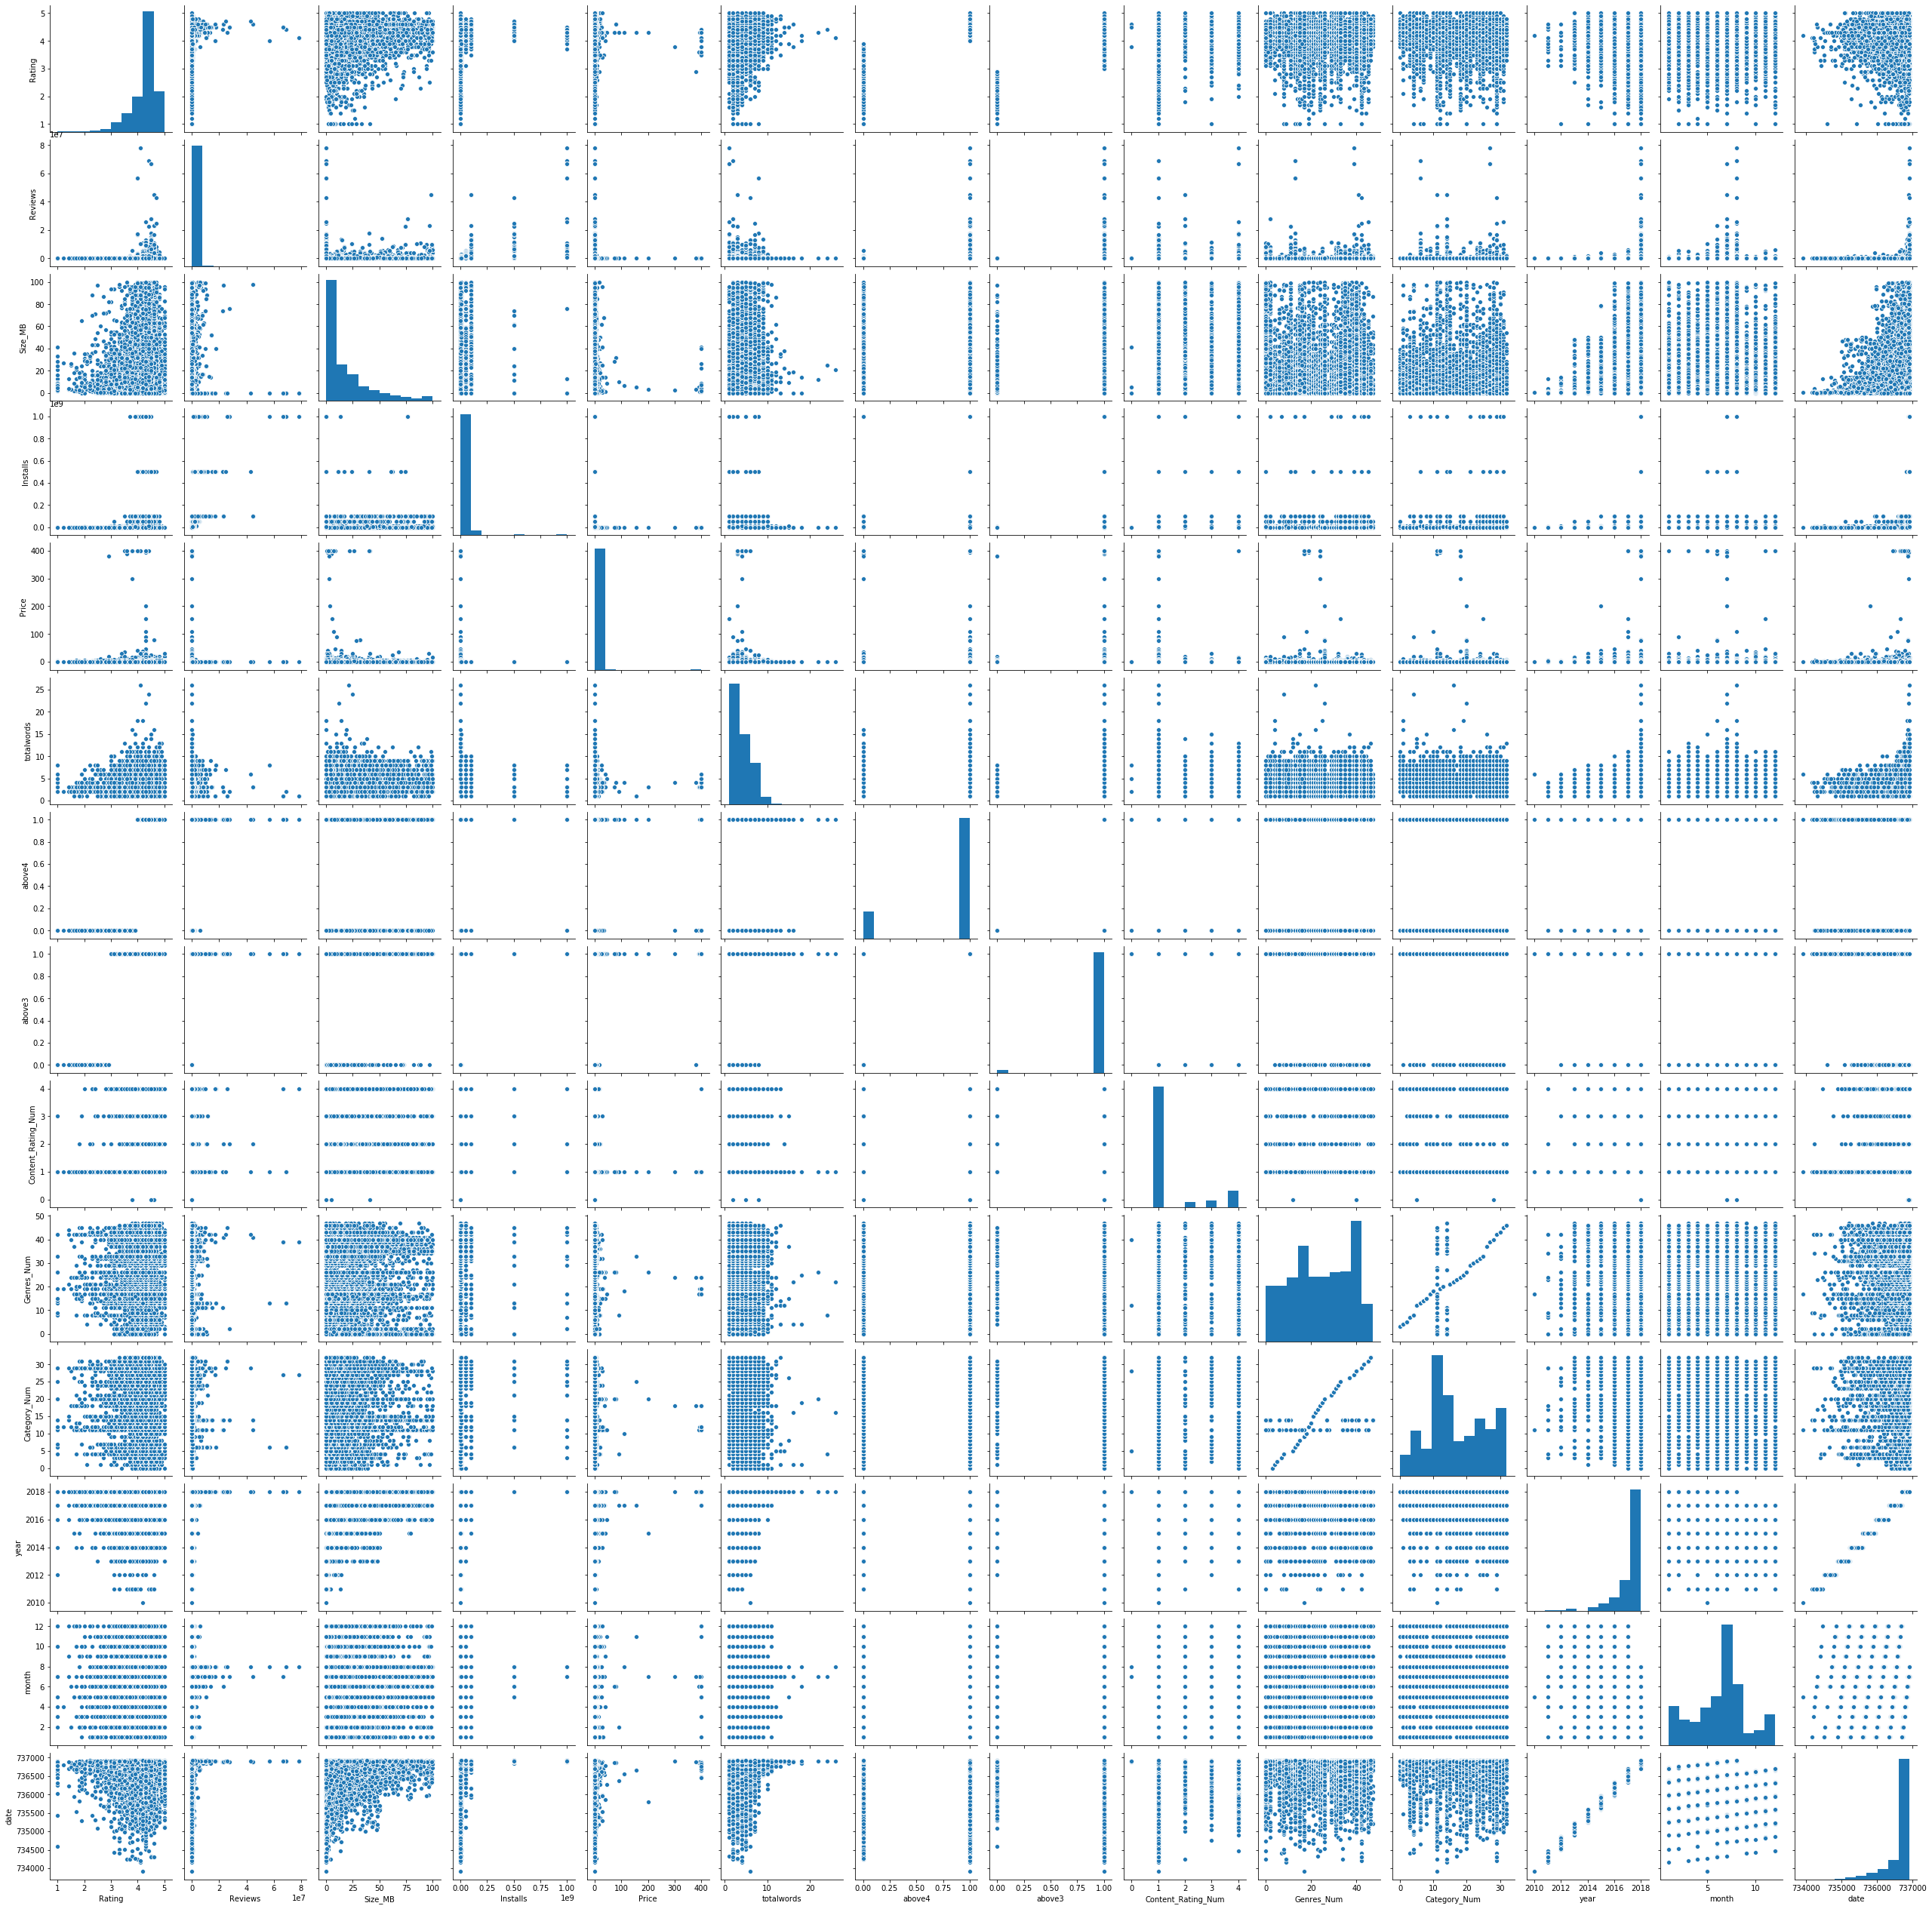

In [69]:
sns.pairplot(df)

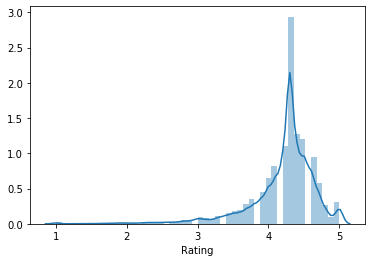

In [70]:
sns.distplot(df['Rating'])

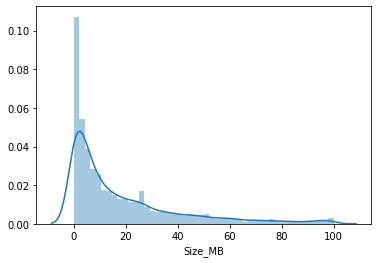

In [71]:
sns.distplot(df['Size_MB'])

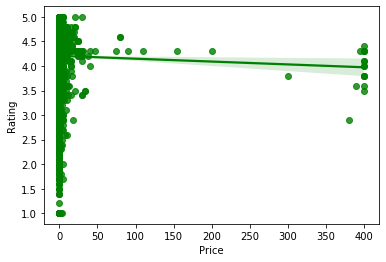

In [72]:
sns.regplot(x="Price", y="Rating", color = 'green', data=df)

In [73]:
#Average rating of Apps in different categories

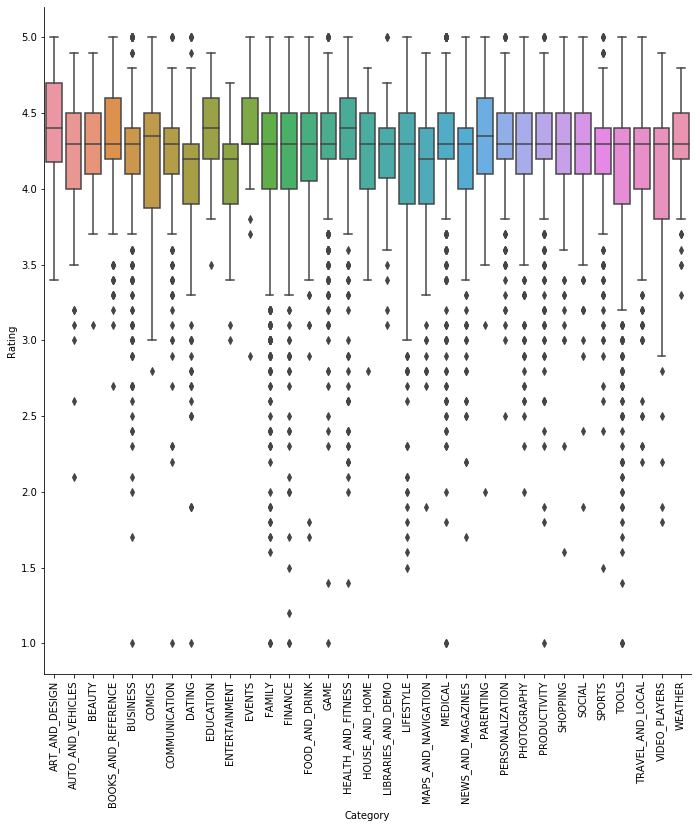

In [74]:
chart = sns.catplot(x='Category', y='Rating', data=df, kind='box',height=10)
for ax in chart.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)

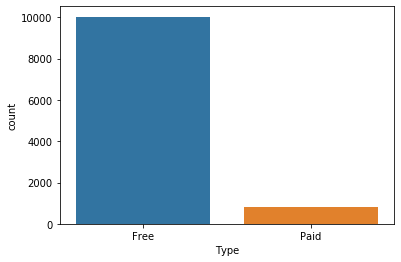

In [75]:
sns.countplot(df['Type'])

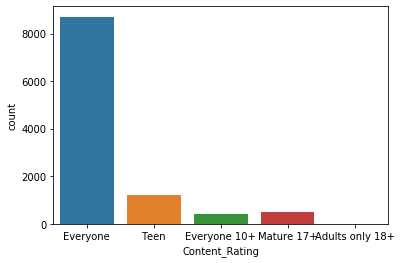

In [76]:
sns.countplot('Content_Rating',data=df)

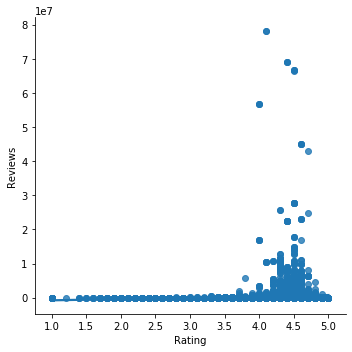

In [77]:
# The number of installs increases, the number of reviews are also increasing 
# if the user has installed the application then only they can give feedback to it 
# Without using an application, reviews cannot be given
sns.lmplot(x='Rating', y='Reviews', data = df, ci= False)

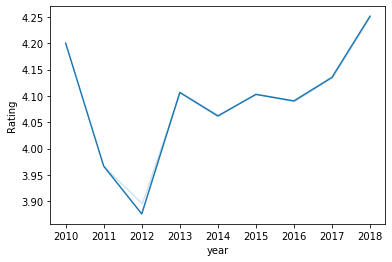

In [78]:
sns.lineplot(x='year', y='Rating', data = df, ci= False)

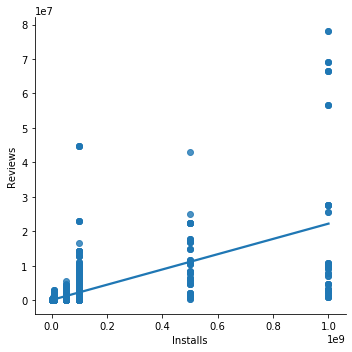

In [79]:

sns.lmplot(x='Installs', y='Reviews', data = df, ci= False)

In [80]:
# sns.regplot(x="Reviews", y="Rating", color = 'darkorange',data=df[df['Reviews']<1000000]);
# plt.title('Rating VS Reveiws',size = 20)

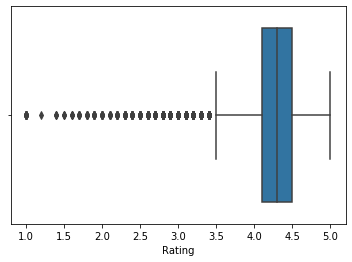

In [81]:
sns.boxplot(x='Rating', data=df)